In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch_geometric.loader import DataLoader
from data_utils import *
from tqdm import tqdm
import pandas as pd

import networkx as nx
import torch_geometric.utils as pyg_utils

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

from data_utils import *
from graph_vae.vae import GraphVAE

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
include_hydrogen = False

properties = ["homo", "lumo", "r2"]

prop_norm_df = create_or_load_property_norm_df()
    
# create dataset and dataloaders
dataset = create_qm9_dataset(
    device=device, 
    include_hydrogen=False, 
    refresh_data_cache=False,
    properties=properties,
    prop_norm_df=prop_norm_df
)

_, val_dataset, _ = create_qm9_data_split(dataset=dataset)

mol_indices = [8, 190, 59, 101]
mol_indices = [8]
val_dataset = val_dataset[mol_indices]

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# old: ./checkpoints/graph_vae_20240416_221922.pt
model = GraphVAE.from_pretrained(checkpoint_path="./checkpoints/graph_vae_20240502_125508.pt").to(device)
model.eval()
# old: ./checkpoints/graph_vae_20240416_225315.pt
model_split = GraphVAE.from_pretrained(checkpoint_path="./checkpoints/graph_vae_20240503_021631.pt").to(device)
model_split.eval()
print()

In [3]:
model = model_split

In [4]:
#ref_z = model.z_to_property_z(model.encode_mean(next(iter(val_loader))))
ref_z = model.encode_mean(next(iter(val_loader)))[:, 16:]
ref_z.shape

torch.Size([1, 112])

In [5]:
import pandas as pd

z_list = []
smiles_list = []
prop_list = []
for batch in tqdm(loader):
    z = model.encode_mean(batch).detach().cpu()
    z = z[:, 16:]
    #z = model.z_to_property_z(z)
    z_list.append(z)
    smiles_list.extend(batch.smiles)
    prop_list.append(model.denormalize_properties(batch.y))

z_dataset = torch.concat(z_list)
y_dataset = torch.concat(prop_list)

  0%|          | 0/501 [00:00<?, ?it/s]

100%|██████████| 501/501 [01:09<00:00,  7.20it/s]


In [6]:
l2_distance = torch.sum((z_dataset - ref_z.detach().cpu())**2, dim=1).sqrt()
df = pd.DataFrame({
    "smiles": smiles_list,
    "distance": l2_distance,
    "properties": y_dataset.tolist()
})
df.sort_values(by="distance", inplace=True)
df.head()

,smiles,distance,properties
44218,[H]N1C([H])([H])C(=O)[C@]1([H])[C@]1([H])OC([H...,0.000002,"[-6.547059535980225, -0.623140811920166, 1136...."
44938,[H]N1C([H])([H])C(=O)[C@]2([H])OC([H])([H])C([...,1.218404,"[-6.247734069824219, -0.7755244970321655, 1032..."
44916,[H]C1=C2C(=O)C([H])([H])N([H])[C@@]2([H])C([H]...,1.605665,"[-6.261340141296387, -1.4966262578964233, 1106..."
45650,[H]N1C([H])([H])C(=O)[C@]2([H])O[C@]2([H])C([H...,1.642114,"[-6.198753356933594, -0.8000147342681885, 1053..."
33760,[H]C1([H])C([H])([H])[C@@]2([H])[C@@]([H])(C#N...,1.665608,"[-7.461361885070801, 0.029932528734207153, 102..."


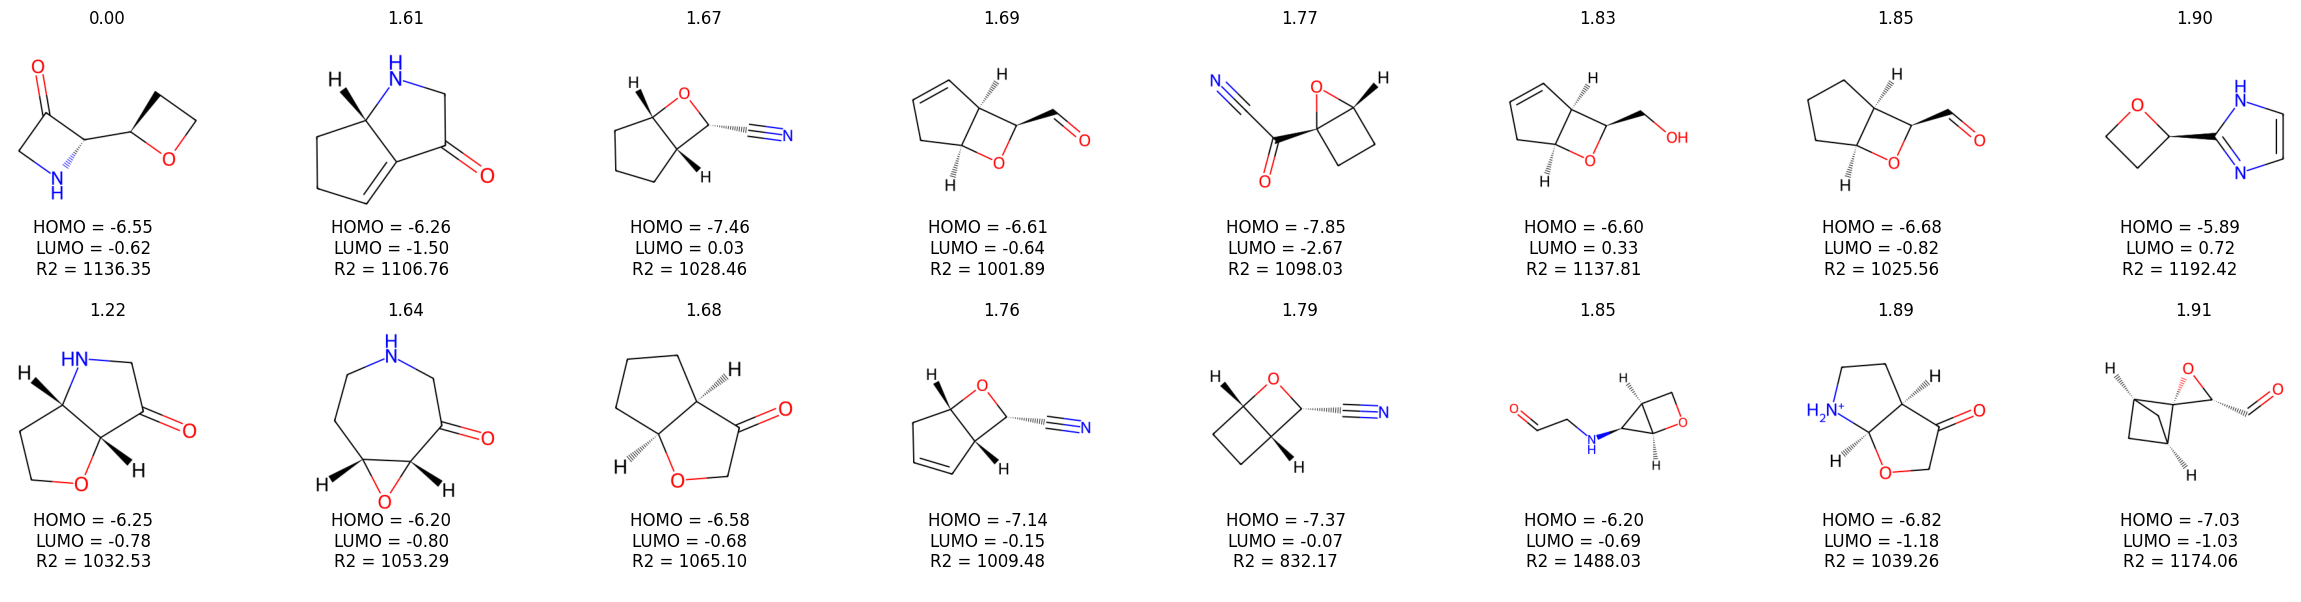

In [7]:
num_mols = 16
cols = num_mols // 2
fig, axis = plt.subplots(2, cols, figsize=(3 * cols, 3 * 2))
axis = axis.flatten("F")

index = 0
for _, row in df.head(num_mols).iterrows():
    mol = Chem.MolFromSmiles(row["smiles"])

    axis[index].imshow(Draw.MolToImage(mol))
    text = ""
    for i, name in enumerate(model.properties):
        text += f"{name.upper()} = {row['properties'][i]:.2f}\n"
    axis[index].set_title(f"{row['distance']:.2f}")
    axis[index].text(128, 256 + 32, 
            text,
            ha='center', va="top", fontsize=12)
    axis[index].axis("off")
    index += 1

plt.tight_layout()
plt.show()